#### RNN with LSTMs Language Model using Skip-Gram Dense Embeddings

In [1]:
# imports 
from gensim.models import Word2Vec
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter 
from itertools import chain

import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Bidirectional


import utils

In [2]:
# constants 
SENTENCE_BEGIN = "<s>"
SENTENCE_END = "</s>"
PADDING = "<pad>"
UNK = "<unk>"

# hyperparameters - may change 
EMBEDDINGS_SIZE = 100
BATCH_SIZE = 128
SEQUENCE_LENGTH = 10
NUM_EPOCHS = 15


# may either be country or metal
GENRE = 'metal' 

# change to save a newly trained model
SAVE_PATH = 'foo'
SHOULD_SAVE = False 

# change to load in an already trained model for sequence generation 
LOAD_PATH = 'metal_lstm_model_epoch20_full'
SHOULD_LOAD = False 

In [3]:
# read in cleaned data
if GENRE == 'country':
    train_lines = pd.read_csv('data/country_train.csv', header=None)[0].tolist()
    val_lines = pd.read_csv('data/country_val.csv', header=None)[0].tolist()
    test_lines = pd.read_csv('data/country_test.csv', header=None)[0].tolist()

elif GENRE == 'metal':
    train_lines = pd.read_csv('data/metal_train.csv', header=None)[0].tolist()
    val_lines = pd.read_csv('data/metal_val.csv', header=None)[0].tolist()
    test_lines = pd.read_csv('data/metal_test.csv', header=None)[0].tolist()

else:
    raise ValueError('Incorrect genre given.')


print("Number of training lines:", len(train_lines))
print("Number of validation lines:", len(val_lines))
print("Number of test lines:", len(test_lines))
print('Lyric Example:', train_lines[0])

Number of training lines: 149771
Number of validation lines: 18610
Number of test lines: 19108
Lyric Example: my journey began after the war of troy


In [4]:
#train_lines = train_lines[:10000]
val_lines = val_lines[:2000]

#### Data Preparation: Tokenize Lyrics, Pad Sequences, Create Dense Word Embeddings

In [5]:
# tokenize and add a single sentence start and end token around each sequence 
train_tokens = [utils.tokenize_line(line, ngram=1) for line in train_lines] 
val_tokens = [utils.tokenize_line(line, ngram=1) for line in val_lines] 
test_tokens = [utils.tokenize_line(line, ngram=1) for line in test_lines] 

Mean Length: 8.331432653851547
Median Length: 8.0
90th Percentile Length: 12.0
Max Length: 110


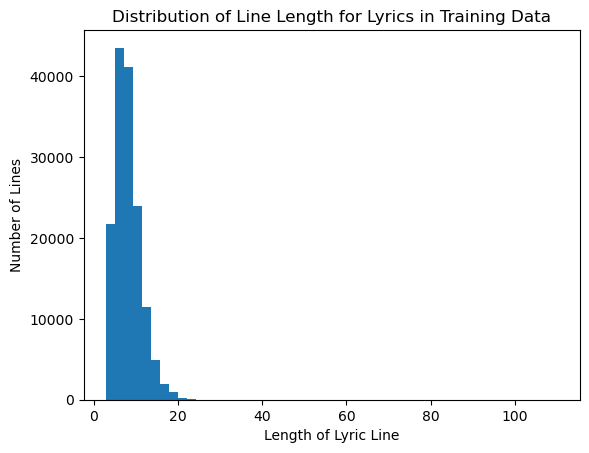

In [6]:
# plot lengths of lyric lines to help determine an appropriate length to pad/truncate to
train_sequence_lengths = [len(seq) for seq in train_tokens]

print("Mean Length:", np.mean(train_sequence_lengths))
print("Median Length:", np.median(train_sequence_lengths))
print("90th Percentile Length:", np.percentile(train_sequence_lengths, 90))
print("Max Length:", np.max(train_sequence_lengths))

plt.hist(train_sequence_lengths, bins=50)
plt.xlabel("Length of Lyric Line")
plt.ylabel("Number of Lines")
plt.title("Distribution of Line Length for Lyrics in Training Data")
plt.show()

In [7]:
def adjust_sequence_length(tokenized_seqs: list, sequence_length: int = SEQUENCE_LENGTH) -> list:
    """
    Pads or truncates all sequences in the provided list to the same length. 
    Adds padding tokens to the left for too-short sequences and truncates to the right 
    for too-long sequences (method based on experimentation with left/right padding/truncation)

    Args:
        tokenized_seqs (list): A list of lists of tokens. Each inner list represents a sequence with tokens as elements
        sequence_length (int): The desired length for all of the sequences
        padding_token (str): The token that should be used to pad short sequences to the proper length

    Returns:
        size_adjusted_sequences (list): A list of lists of tokens, where each inner list is the same length
    """
    size_adjusted_sequences = []
    for sequence in tokenized_seqs:
        if len(sequence) < sequence_length:
            # too short, add padding
            num_padding = sequence_length - len(sequence)
            size_adjusted_sequences.append( ([PADDING] * num_padding) + sequence)
        else:
            # truncate sequences longer than the chosen length 
            size_adjusted_sequences.append(sequence[:sequence_length])
            

    return size_adjusted_sequences


def replace_unknowns_train(tokenized_seqs: list) -> list:
    """"
    Replaces words that occur only once with an UNK token

    Args:
        tokenized_seqs (list): A list of lists of tokens. Each inner list represents a sequence with tokens as elements

    Returns:
        Tokenized sequences with low frequency words replaced with the unknown special token 
    """
    # concatenate all sequences together 
    all_tokens = list(chain(*tokenized_seqs))
    token_counts = Counter(all_tokens)

    # Replace words with low frequencies to UNK so that we can calculate perplexity on test data with unknown words 
    cleaned_tokenized_seqs = []
    for seq in tokenized_seqs:
        cleaned_seq = [tok if token_counts[tok] > 1 else UNK for tok in seq]
        cleaned_tokenized_seqs.append(cleaned_seq)

    return cleaned_tokenized_seqs


size_adjusted_sequences_train = adjust_sequence_length(train_tokens)
cleaned_sequences_train = replace_unknowns_train(size_adjusted_sequences_train)
print("Number of sequences:", len(cleaned_sequences_train))
print("Length of Sequences:", len(cleaned_sequences_train[0]))

Number of sequences: 149771
Length of Sequences: 10


In [8]:
# Use Tokenizer to map each token to a unique index 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(cleaned_sequences_train)
encoded_sequences_train = tokenizer.texts_to_sequences(cleaned_sequences_train)

print("Vocab Size:", len(tokenizer.word_index))
print('encoded examples:', '\n', encoded_sequences_train[0], '\n', encoded_sequences_train[1])

Vocab Size: 14023
encoded examples: 
 [2, 13, 632, 1515, 409, 4, 191, 10, 4883, 3] 
 [2, 5, 139, 237, 11, 392, 6, 13, 346, 9]


In [9]:
# create word embeddings using skip gram algorithm
word_embeddings = Word2Vec(sentences=cleaned_sequences_train, vector_size=EMBEDDINGS_SIZE, window=5, sg=1, min_count=1)
print('Vocab size for word embeddings:', len(word_embeddings.wv))

Vocab size for word embeddings: 14023


In [10]:
# Function that gives mappings from words to their embeddings and  
# indexes from the tokenizers to their embeddings

def map_embeddings(embeddings: Word2Vec, tokenizer: Tokenizer) -> (dict, dict):
    ''' Creates mappings between different token representations 
    Arguments:
        embeddings: Word2Vec word embeddings for the data (maps tokens to embedding vectors)
        tokenizer: Tokenizer used to tokenize the data (maps token to index)
    Returns:
        (dict): mapping from word to its embedding vector
        (dict): mapping from index to its embedding vector
    '''
    # initialize dictionaries 
    token_to_embedding = {}
    index_to_embedding = {}

    # tokenizer maps tokens to unique indices 
    for token, index in tokenizer.word_index.items():
        embedding = embeddings[token]

        token_to_embedding[token] = embedding
        index_to_embedding[index] = embedding

    return (token_to_embedding, index_to_embedding)


token_to_embedding, index_to_embedding = map_embeddings(word_embeddings.wv, tokenizer)

# Fill in unused index zero to avoid dimension mismatch
index_to_embedding[0] = [0] * EMBEDDINGS_SIZE

#### Generate Samples for Training

In [11]:
def data_generator(data: list, num_sequences_per_batch: int, index_2_embedding: dict) -> (np.array, np.array):
    '''
    Returns a data generator to train the neural network in batches

    X data will be represented in embedding form.
    Y data will be represented with one hot vectors. 

    Args:
    data (list of lists): tokenized sequences represented by their unique index encodings 
    num_sequences_per_batch (int): batch size yielded on each iteration of the generator 
    index_2_embedding (dict): mapping between unique token indices and dense word embeddings 

    Returns:
    X_batch_embeddings (3-D numpy array): sequences of embeddings with dimensions (batch size, num timesteps, embedding size)
                                          Take the first (SEQUENCE_LENGTH - 1) tokens of each sequence
    y_batch (3-D numpy array): sequences of one hot vectors with dimensions (batch size, num timesteps, vocab size)
                                          Take the last (SEQUENCE_LENGTH - 1) tokens of each sequence 
                                          (X shifted forward one token so that the neural net predicts 
                                          the next word in the sequence for each timestep)
    '''
    # iterate over data in batches - stored in the form of unique token indices 
    i = 0
    while True:
        # get samples that we'd like to train on for this batch 
        data_batch = data[i:i+num_sequences_per_batch]

        # increment i with each batch 
        i += num_sequences_per_batch

        # split into X and Y -- shifted sequence so that for each timestep, Y is the token that follows X 
        X_data = [sequence[:-1] for sequence in data_batch]
        Y_data = [sequence[1:] for sequence in data_batch]

        # get embeddings for X data 
        X_embeddings = []
        for X_sequence in X_data:
            X_sequence_embeddings = [index_2_embedding[token_idx] for token_idx in X_sequence]
            X_embeddings.append(X_sequence_embeddings)

        # get one hot vectors for Y data 
        Y_one_hot_vectors = []
        for Y_sequence in Y_data:
            Y_one_hot = to_categorical(Y_sequence, num_classes=len(index_2_embedding))
            Y_one_hot_vectors.append(Y_one_hot)

        # yield statement instead of return for generator 
        yield(np.array(X_embeddings), np.array(Y_one_hot_vectors))


# demo the data generator
demo_data_generator = data_generator(encoded_sequences_train, BATCH_SIZE, index_to_embedding)
demo_sample = next(demo_data_generator)
print("X batch shape:", demo_sample[0].shape)
print("y batch shape:", demo_sample[1].shape)


X batch shape: (128, 9, 100)
y batch shape: (128, 9, 14024)


In [12]:
# prepare validation data
# Since the model does not know about these sequences beforehand, 
# unknown words are those that do not appear in the training vocabulary 
def encode_new_sequences(tokenized_seqs: list, tokenizer) -> list:
    """"
    Replaces words that are not in the tokenizer's vocab with the unknown special token and encodes it to 
    unique token indices specified by the provided Tokenizer.

    Args:
        tokenized_seqs (list): A list of lists of tokens. Each inner list represents a sequence with tokens as elements
        tokenizer: Tokenizer used maps token to index

    Returns:
        Encoded sequences with words not in the training vocabulary replaced with the unknown special token 
    """
    cleaned_tokenized_seqs = []
    for seq in tokenized_seqs:
        cleaned_seq = [tok if tok in tokenizer.word_index.keys() else UNK for tok in seq]
        cleaned_tokenized_seqs.append(cleaned_seq)

    return tokenizer.texts_to_sequences(cleaned_tokenized_seqs)

encoded_sequences_val = encode_new_sequences(val_tokens, tokenizer)

#### Create and Train Model

In [13]:
def lstm_rnn(train_data: np.array,
             index_2_embedding: dict, 
             num_epochs: int=1, 
             num_sequences_per_batch: int=BATCH_SIZE, 
             sequence_length: int=SEQUENCE_LENGTH,
             embedding_size: int=EMBEDDINGS_SIZE):
    """
    Creates and trains an RNN with LSTM cells using given training data and batch size.

    Args:
        train_data (list of lists): encoded sequences of training data represented by token indices 
        index_2_embedding (dict): mapping from token index -> word2vec embeddings 
        num_epochs (int): number of training epochs
        num_sequences_per_batch (int): batch size for training data 
        sequence_length (int): number of tokens in each training sample 
        embedding_size (int): size of the dense word embeddings used to represent tokens 
    Returns:
        A trained Neural Network language model
    """
    # define model parameters
    hidden_units = 200
    hidden_input_dim = (sequence_length - 1, embedding_size)      # (number of steps, number of features per step)
    output_dim = len(index_2_embedding)                            # vocab size 

    # instantiate model
    model = Sequential()

    # hidden layer
    model.add(Bidirectional(LSTM(hidden_units, 
                                 input_shape=hidden_input_dim,
                                 return_sequences=True)))

    # output layer
    model.add(Dense(units=output_dim, activation='softmax'))

    # configure the learning process
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=["top_k_categorical_accuracy"])
    
    # total number of batches per epoch 
    steps_per_epoch = len(train_data)//num_sequences_per_batch
   
    for i in range(num_epochs):
        if i % 5 == 0:
            print("Epoch", i)

        # create a new data generator for us to iterate through
        train_generator = data_generator(train_data, num_sequences_per_batch, index_2_embedding)

        # train model 
        model.fit(x=train_generator, steps_per_epoch=steps_per_epoch)

    model.summary()
    return model

In [14]:
# create and train model
model = lstm_rnn(np.array(encoded_sequences_train), index_to_embedding, num_epochs=NUM_EPOCHS)

# save trained model 
if SHOULD_SAVE:
    model.save(SAVE_PATH)

Epoch 0
1170/1170 [==============================] - 290s 248ms/step - loss: 0.1946 - top_k_categorical_accuracy: 0.9819
Epoch 5
 794/1170 [===================>..........] - ETA: 1:23 - loss: 0.1006 - top_k_categorical_accuracy: 0.9878

#### Create functions to generate new sequences 

In [ ]:
def generate_sequences(model: Sequential, 
					  tokenizer: Tokenizer, 
					  index_2_embedding: dict, 
					  num_seq: int,
					  verbose: bool = True,
					  file_path: str = None):
	'''
	Generates a given number of sequences using the given RNN language model.
	Will begin the sequence generation with n-1 SENTENCE_BEGIN tokens.
	Returned sequences will have the BEGIN, END, and PADDING tokens removed

	Writes generated sequences to file_path, if provided 

	Args:
		model: RNN language model
		tokenizer: the keras preprocessing tokenizer
		index_2_embedding: mapping from token index -> word2vec embeddings 
		num_seq: the number of sequences to generate 
		verbose: If True, prints progress of sequence generation 
		file_path (str): path of file to write the generated sequences to, with one sequence per line 

	Returns: 
		A list of strings, where each string is a generated sequence with special tokens removed 
	'''
	seed = [SENTENCE_BEGIN] * (SEQUENCE_LENGTH - 1) 
	
	sequences = []
	for i in range(num_seq):
		# print progress 
		if verbose and i % 10 == 0:
			print("Generating line", i, "/", num_seq)



		seq = generate_seq(model, tokenizer, index_2_embedding, seed)
		seq = ' '.join(seq)

		# remove special tokens
		seq = seq.replace(SENTENCE_BEGIN, '')
		seq = seq.replace(SENTENCE_END, '')
		seq = seq.replace(PADDING, '')
		seq = seq.replace(UNK, '')

		sequences.append(seq.strip())

	if file_path is not None:
		with open(file_path, 'w') as f:
			for seq in sequences:
				f.write(seq + '\n')
		
	return sequences


def generate_seq(model: Sequential, 
				 tokenizer: Tokenizer, 
				 index_2_embedding: dict, 
				 seed: list):
	'''
	Generates a single sequence using the given model starting with a SENTENCE_BEGIN and ending with a SENTENCE_END token. 
	Since an RNN takes input sequences of fixed length, use a sliding window to continually predict the next word. 

	Args:
		model: RNN language model
		tokenizer: the keras preprocessing tokenizer
		index_2_embedding: mapping from token index -> word2vec embeddings 
		seed: the initial tokens to feed the RNN
	Returns: 
		An array of tokens representing a sequence 
	'''
	padding_index = tokenizer.word_index.get(PADDING)
	sentence_begin_index = tokenizer.word_index.get(SENTENCE_BEGIN)
	sentence_end_index = tokenizer.word_index.get(SENTENCE_END)

	# track the unique token indices for the sequence 
	sequence_indices = [tokenizer.word_index.get(tok) for tok in seed] 

	# number of timesteps that the model expects as input
	input_length = SEQUENCE_LENGTH - 1

	# until we get a SENTENCE_END token
	while sequence_indices[-1] != sentence_end_index:
		# get latest tokens to use as inputs 
		input_sequence = sequence_indices[-1*input_length:]

		# convert the input sequence to embeddings
		input_embeddings = np.array([[index_2_embedding[idx] for idx in input_sequence]])

		# get probability distribution on vocabulary for the next token in the sequence 
		prediction = model.predict(input_embeddings, verbose=False)[0][-1]

		# sample from the probability distribution 
		next_tok_idx = np.random.choice(len(prediction), p=prediction)

		# skip mid-sentence SENTENCE_BEGIN and PADDING tokens
		if next_tok_idx == sentence_begin_index or next_tok_idx == padding_index:
			continue

		# add newly generated token to our sequence 
		sequence_indices.append(next_tok_idx)

	# convert to words 
	tokenizer_words = list(tokenizer.word_index.keys())
	tokenizer_indices = list(tokenizer.word_index.values())
	sequence = [tokenizer_words[tokenizer_indices.index(idx)] for idx in sequence_indices]
	return sequence

In [ ]:
# load in model (if we have a pre-trained one that we'd like to generate sequences for)
#if SHOULD_LOAD or True:
    #model = keras.saving.load_model(LOAD_PATH)
    
# Generate new lyrics 
generated_sequences = generate_sequences(model, tokenizer, index_to_embedding, num_seq=100)
print("Sample Generated Lyrics:\n")
for seq in generated_sequences:
    print(seq)

Generating line 0 / 100
Generating line 10 / 100
Generating line 20 / 100
Generating line 30 / 100
Generating line 40 / 100
Generating line 50 / 100
Generating line 60 / 100
Generating line 70 / 100
Generating line 80 / 100
Generating line 90 / 100
Sample Generated Lyrics:

and to to
pain
and ' ' chased
and on and fear
and find for
and
and you ' ' wrong
and myself back
and end

back and may
and ' ' ' lie
and hate can do what is may we can do
and
and on now ?
and last
and earth
as as you came 's
and back
pain
and hate
alive


and ' ' ' ' days
and back
and shot back
joy
and staring now
and die ?
all you
and judge
and america
and find back
and target

and pieces
i close
and rage

and ' ' ' ' around disease getting caught in get down ' long ago

and find the game
and ' ' just lie
and can have hands

and only
to i ' ' day
like
and ' ' '
and back now
it bad
and last
true
and ' ' long ,
everything ' ' just
and everything and died warm
and back but ' dead

and end
everything i 've more than th

#### Calculate Perplexity 


In [ ]:
def calculate_perplexity(encoded_sequence: list, model: Sequential, 
                        tokenizer: Tokenizer, 
                        index_2_embedding: dict,
                        verbose: bool = False):
    '''
    Computes the perplexity of a single sequence by finding the probability that the model will generate 
    this sequence. Uses a sliding window to continuously predict the next word, and finds the softmax probability
    associated with the true word. 

    Args:
        encoded_sequence (list): a single sequence represented by its Tokenizer encodings 
        model: RNN language model
        tokenizer: the keras preprocessing tokenizer
        index_2_embedding: mapping from token index -> word2vec embeddings 
        verbose (bool): If true, prints information about the sequence and the probability of each word 
    Returns: 
        the perplexity of the sequence 
    ''' 
    padding_index = tokenizer.word_index.get(PADDING)
    sentence_begin_index = tokenizer.word_index.get(SENTENCE_BEGIN)

    # shift Y forward one token to represent the next word predictions 
    X_data = encoded_sequence[:-1]
    Y_data = encoded_sequence[1:]

    # seed with SEQUENCE_LENGTH - 2 sentence begins (first token in X is a sentence begin as well),
    # inch window along to predict the next word 
    encoded_input = [sentence_begin_index] * (SEQUENCE_LENGTH - 2) + X_data

    input_length = SEQUENCE_LENGTH - 1

    # we will be finding the log of the probability of our model generating this sequence 
    Y_pred_log_prob = 0

    # track the number of meaningful tokens 
    N = 0

    # for each word in Y (all tokens except SENTENCE_BEGIN)
    for i, y in enumerate(Y_data):
        # use a sliding window over the input, where the input sequence are the tokens preceding y 
        input_sequence = encoded_input[i:input_length+i]

        # convert the input sequence to embeddings
        input_embeddings = np.array([[index_2_embedding[idx] for idx in input_sequence]])

        # get probability distribution on vocabulary for the next token in the sequence 
        prediction = model.predict(input_embeddings, verbose=False)[0][-1]

        # index y to get the predicted probability of the true value 
        y_pred_prob = prediction[y] 

        # print information to help with debugging 
        if verbose:
            print("Encoded input sequence:", input_sequence)
            print("Encoded y to predict:", y)
            print("Probability of next token being y:", y_pred_prob)

        Y_pred_log_prob += np.log(y_pred_prob)

        # only include meaningful tokens in our token count 
        if y != padding_index and y != sentence_begin_index:
            N += 1

    # compute probability of our model generating this sequence as well as the perplexity 
    Y_pred_prob = np.exp(Y_pred_log_prob)
    perplexity = Y_pred_prob ** (-1/N)
    
    return perplexity


def mean_perplexity(val_data: np.array, 
                    model: Sequential, 
                    tokenizer: Tokenizer, 
                    index_2_embedding: dict):
    """" 
    Computes the average perplexity of all sequences in the given data using the given model.

    Args:
        encoded_sequence (list): a single sequence represented by its Tokenizer encodings 
        model: RNN language model
        tokenizer: the keras preprocessing tokenizer
        index_2_embedding: mapping from token index -> word2vec embeddings 
        verbose (bool): If true, prints information about the sequence and the probability of each word 
    Returns: 
        The average perplexity of the provided sequences 
    """
    total_samples = len(val_data)

    perplexities = []
    for i, seq in enumerate(val_data):
        if i % 25 == 0:
            print("Computing perplexity of line", i, "/", total_samples)
        perplexities.append(calculate_perplexity(seq, model, tokenizer, index_2_embedding))
    return np.mean(perplexities)

#TODO - probably increase, just takes about a minute for every 100 sequences 
#calculate_perplexity(encoded_sequences_val[0], model, tokenizer, index_to_embedding, verbose=True)
mean_perplexity(encoded_sequences_val[:500], model, tokenizer, index_to_embedding)

Computing perplexity of line 0 / 500
Computing perplexity of line 25 / 500
Computing perplexity of line 50 / 500
Computing perplexity of line 75 / 500
Computing perplexity of line 100 / 500
Computing perplexity of line 125 / 500
Computing perplexity of line 150 / 500
Computing perplexity of line 175 / 500
Computing perplexity of line 200 / 500
Computing perplexity of line 225 / 500
Computing perplexity of line 250 / 500
Computing perplexity of line 275 / 500
Computing perplexity of line 300 / 500
Computing perplexity of line 325 / 500
Computing perplexity of line 350 / 500
Computing perplexity of line 375 / 500
Computing perplexity of line 400 / 500
Computing perplexity of line 425 / 500
Computing perplexity of line 450 / 500
Computing perplexity of line 475 / 500


4401.174542943271

#### Experimenting with Hyperparameters 

To find our final configuration for our RNN + LSTM model, we will test out hyperparameters such as sequence length, embedding size, number of epochs, and model structure. Due to time constraints, we will run these experiments on a subset of the training and validation data (10,000 training lines and 500 validation lines). Test data is limited to control training time; validation data is limited to control perplexity evaluation time (which is a particularly slow function). 

-----------------------------------------------------------------------------------------------------------------------------------------

| Genre       	| Word Embedding Size 	| Sequence Length 	| Number of Epochs 	| Model Structure                   	| Mean Validation Perplexity 	| Generated Examples                                                                                                                                                                                                   	|
|-------------	|---------------------	|-----------------	|------------------	|-----------------------------------	|----------------------------	|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------	|
| Country     	| 100                 	| 10              	| 20               	| 200 hidden units                  	| 264.0667752293233          	| my own 'em , the party<br>if the break and now she wanting o<br>crawl sign<br>look<br>used you become where warden<br>the sun .                                                                                      	|
| Country     	| 50                  	| 10              	| 20               	| 200 hidden units                  	| 454.2141099684709          	| 's among time roof tight are at<br>strong part record<br>exist divine laugh proud warm six for<br>battle porch weary hungry news shine lonely quarter ai n't the same the same boy i tear                            	|
| Country     	| 150                 	| 10              	| 20               	| 200 hidden units                  	| 441.08825950748917         	| instead half forever mat straight searchin under time<br>drop learning my finest lets voice border shining , with of<br>sinner knife might you wiped changed guess you 'll gon be drink man                          	|
| Country     	| 100                 	| 5               	| 20               	| 200 hidden units                  	| 347.79992897087277         	| what know<br>by have if wo this dear on on is shame them i 'm finally i do n't fool then stand '<br>own                                                                                                              	|
| Country     	| 100                 	| 15              	| 20               	| 200 hidden units                  	| 485.91876699708564         	| sometimes did how cried look )<br>thanks complete good-bye money go reach me<br>ah yea & born else<br>writers darlin think tried came ta without me                                                                  	|
| Country     	| 100                 	| 10              	| 10               	| 200 hidden units                  	| 535.7385514266462          	| war pigeon rail up woman river counting slow<br>but did move might anything complain clouds<br>skin special fly reaching frame valley throw down<br>darlin about seen saw fish fell chance                           	|
| Country     	| 100                 	| 10              	| 40               	| 200 hidden units                  	| 688.1449810877316          	| mistakes unfair ; from seasons<br>going ! where outside ring asphalt honky-tonk wool<br>my graveside weight crying fill enough<br>half try this graveside feather been closed better tonight me                      	|
| Country     	| 100                 	| 10              	| 40               	| 200 hidden units<br>+ 0.2 Dropout 	| 688.9395738510657          	| we 're through with you say may you fill care '<br>woman leave hurry survived solid love<br>tender a serious sill kicked eyed thin<br>almost forty loves then be .                                                   	|
|             	|                     	|                 	|                  	|                                   	|                            	|                                                                                                                                                                                                                      	|
| Heavy Metal 	| 100                 	| 10              	| 20               	| 200 hidden units                  	| 989.6465879561613          	| teach sharp voice impossible into throat<br>he swim hunter mystery been still forever<br>( bought ^ curse wolf hurt slowly agree<br>cast thee l. friend some<br>another without flies lie killed toy depressed       	|
| Heavy Metal 	| 50                  	| 10              	| 20               	| 200 hidden units                  	| 682.696828268074           	| thinking minority most remains leap countdown horizon fear , turn your<br>blade called<br>heading clean power ages shall minority ending brown<br>lord part hand this force                                          	|
| Heavy Metal 	| 150                 	| 10              	| 20               	| 200 hidden units                  	| 547.4438419767572          	| yo understood odin malice leader lair glass place faith , the only blood<br>and we all on energy ,<br>holding writhing ai line worship to fight to the , to my mission<br>nothing happened itself feed to prove odds 	|
| Heavy Metal 	| 100                 	| 5               	| 20               	| 200 hidden units                  	| 333.9428479548894          	| bend will becoming<br>we and you told their the the voice heart ] standing gabrielle the<br>i will boys listen overload inside<br>of of more                                                                         	|
| Heavy Metal 	| 100                 	| 15              	| 20               	| 200 hidden units                  	| 845.0837951396505          	| but made<br>honey pick tongues<br>panic spirit none dirt wall thee drifted baby<br>soon -i<br>jump                                                                                                                   	|
| Heavy Metal 	| 100                 	| 10              	| 10               	| 200 hidden units                  	| 557.8584412735338          	| crime bed kill crowned fuel died break<br>wonder but stronger incendiary perfect angry water scenes<br>with enough chide wipe and horizon past ashes cause<br>valiant .. yo blind courageous sacrifice pass          	|
| Heavy Metal 	| 100                 	| 10              	| 40               	| 200 hidden units                  	| 555.9454288149526          	| foul back coming 're superheroes<br>glow front ride<br>true faith to win great all there coming to the floor )                                                                                                       	|
| Heavy Metal 	| 100                 	| 10              	| 40               	| 200 hidden units<br>+ 0.2 Dropout 	| 523.1969617748815          	| he high set i divide free<br>believer heavy gone hand throat brown<br>well made control leap and<br>lead before long then naked if there tried                                                                       	|



#### Key Findings 


